In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [0]:

tf.__version__

'2.0.0'

In [0]:
!nvidia-smi

Mon Oct 21 05:11:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
ds = tfds.load('oxford_iiit_pet', shuffle_files=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/1.1.0. Subsequent calls will reuse this data.


In [0]:
ds

{'test': <_OptionsDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1)}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8}>,
 'train': <_OptionsDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1)}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8}>}

In [0]:
def normalize_image(ele):
  image = ele['image']
  label = ele['label']
  paddings = tf.constant([[28,28], [28,28], [0,0]])
  
  image = tf.image.resize(image, size = [224,224])
  image = tf.pad(image, paddings, 'CONSTANT')
  image = tf.image.random_crop(image, size = [224,224,3])
  image = (image - tf.reduce_min(image))/(tf.reduce_max(image)-tf.reduce_min(image))
  return image, label


ds_train = ds['train'].map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).repeat().shuffle(100).batch(16).prefetch(1)
ds_test = ds['test'].map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).repeat().shuffle(100).batch(16).prefetch(1)


In [0]:
print(ds['train'])

<_OptionsDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1)}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8}>


In [0]:
ds_test_iterator = iter(ds_test)

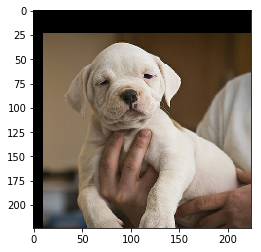

In [0]:
x,y = next(ds_test_iterator)
#print(x)
plt.imshow(x.numpy()[0])

In [0]:
def conv2D(x, filters, kernel=(3,3), strides=(1,1), activation=tf.nn.relu, use_bias=False):
  x = tf.keras.layers.Conv2D(filters, kernel_size=kernel, strides=strides, use_bias=use_bias, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  if activation is not None:
    x = tf.keras.layers.Activation(activation)(x)
  return x


def mini_block(x, trips = [16, 16] , first = False):
  if first:
    x = conv2D(x, trips[0], kernel =  (3,3), strides = (2,2))
  else:
    x = conv2D(x, trips[0], kernel = (3,3), strides = (1,1))
  x = conv2D(x, trips[1], kernel = (3,3), strides = (1,1))
  return x 


def SE_block(x, activations = tf.nn.relu, ratio = 16):
  depth = x.shape[3]
  prev = x
  prev = tf.keras.layers.GlobalAveragePooling2D()(prev)
  prev = tf.keras.layers.Dense(depth//ratio, activation= activations)(prev)
  prev = tf.keras.layers.Dense(depth, activation = tf.nn.sigmoid)(prev)
  x = x * tf.reshape(prev, [-1, 1, 1, depth])
  return x
    

def mesa_block(x, trips = [16,16], repeats = 36, downsample = True):
  prev = x
  for r in range(repeats):
    if r == 0 and downsample:
      prev = conv2D(prev, trips[1], kernel = (1,1), strides = (2,2), activation = None)
      x = mini_block(x, trips = trips, first = True)
      x = SE_block(x)
      x = tf.keras.layers.Add()([x,prev])
    elif r == 0 and not downsample:
      prev = x
      x = mini_block(x, trips = trips)
      x = SE_block(x)
      x = tf.keras.layers.Add()([x,prev])
    else:
      prev = x
      x = mini_block(x, trips = trips)
      x = SE_block(x)
      x = tf.keras.layers.Add()([x, prev])
  return x 

In [0]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = conv2D(inputs, 16, kernel=(3,3), strides=(1,1),)

### Block 1
x = mesa_block(x, trips=[16,16], repeats=18, downsample=False)

### Block 2
x = mesa_block(x, trips=[32, 32], repeats=18)

### Block 3
x = mesa_block(x, trips=[64,64], repeats=18)



x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(37, activation='softmax')(x) #logits 
resnet110 = tf.keras.Model(inputs, x)
resnet110.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_341 (Conv2D)             (None, 224, 224, 16) 432         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_341 (BatchN (None, 224, 224, 16) 64          conv2d_341[0][0]                 
__________________________________________________________________________________________________
activation_335 (Activation)     (None, 224, 224, 16) 0           batch_normalization_341[0][0]    
____________________________________________________________________________________________

In [0]:
step = tf.Variable(0, trainable=False)
boundaries = [1, 82, 123]
values = [0.01, 0.1, 0.1/10, 0.1/100]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

learning_rate = learning_rate_fn(step)

In [0]:
resnet110.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
resnet110.fit(ds_train, epochs=165, steps_per_epoch=230, validation_data=ds_test, validation_steps=10)

Train for 230 steps, validate for 10 steps
Epoch 1/165
230/230 [==============================] - 465s 2s/step - loss: 3.8306 - accuracy: 0.0299 - val_loss: 4.0683 - val_accuracy: 0.0188
Epoch 2/165
230/230 [==============================] - 427s 2s/step - loss: 3.6003 - accuracy: 0.0408 - val_loss: 3.6151 - val_accuracy: 0.0188
Epoch 3/165
230/230 [==============================] - 427s 2s/step - loss: 3.5966 - accuracy: 0.0418 - val_loss: 3.6012 - val_accuracy: 0.0562
Epoch 4/165
230/230 [==============================] - 427s 2s/step - loss: 3.5905 - accuracy: 0.0446 - val_loss: 3.6031 - val_accuracy: 0.0500
Epoch 5/165
230/230 [==============================] - 427s 2s/step - loss: 3.5772 - accuracy: 0.0478 - val_loss: 3.5908 - val_accuracy: 0.0562
Epoch 6/165
230/230 [==============================] - 427s 2s/step - loss: 3.5716 - accuracy: 0.0495 - val_loss: 3.5741 - val_accuracy: 0.0688
Epoch 7/165
230/230 [==============================] - 428s 2s/step - loss: 3.5578 - accuracy

In [0]:
#@title
keras_ResNet50 = tf.keras.applications.ResNet50(include_top=False)
for layer in keras_ResNet50.layers:
  layer.trainable = False

In [0]:
#@title
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = keras_ResNet50(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(37)(x)
x = tf.keras.layers.Softmax()(x)
pretrained_resnet = tf.keras.Model(inputs, x)
pretrained_resnet.summary()

In [0]:
#@title
pretrained_resnet.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pretrained_resnet.fit(ds_train, epochs=10, steps_per_epoch=1850, validation_data=ds_test, validation_steps=100)